In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0305.JPG
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0394.jpg
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0105.jpg
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0104.jpg
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0325.JPG
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0332.JPG
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0296.jpg
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0114.jpg
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0329.jpg
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0100.jpg
/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0299.JPG
/kaggle/in

In [2]:
# Import libraries for data handling, model building, and evaluation
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models  # Added models for ResNet
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
import seaborn as sns
from itertools import cycle

# Import for learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# **Part 2: Define the AlexNet Model**

In [3]:
# Define the Custom AlexNet model with batch normalization
class CustomAlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomAlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.fc1 = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True)
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True)
        )
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# **Part 3: Load and Preprocess the Dataset**

In [4]:
# Define data transformations with enhanced augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(root='/kaggle/input/rice-leaf-diseases/rice_leaf_diseases')
dataset.transform = test_transform  # Default transform, overridden in training

# Print dataset details
print(f"Total images: {len(dataset)}")
print(f"Classes: {dataset.classes}")

Total images: 120
Classes: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


# **Part 4: Train and Evaluate with K-Fold Cross-Validation**

In [5]:
# Define training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience):
    train_loss_values = []
    val_loss_values = []
    train_accuracy_values = []
    val_accuracy_values = []
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_corrects.double() / total_samples * 100
        train_loss_values.append(epoch_train_loss)
        train_accuracy_values.append(epoch_train_acc.item())

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

        epoch_val_loss = running_loss / total_samples
        epoch_val_acc = running_corrects.double() / total_samples * 100
        val_loss_values.append(epoch_val_loss)
        val_accuracy_values.append(epoch_val_acc.item())

        scheduler.step(epoch_val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0
            torch.save(model.state_dict(), f'best_model_fold.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after epoch {epoch + 1}")
                break

    return train_loss_values, val_loss_values, train_accuracy_values, val_accuracy_values

# Define testing function
def test_model(model, test_loader, device):
    model.eval()
    running_corrects = 0
    total_samples = 0
    predictions = []
    true_labels = []
    probabilities = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    accuracy = running_corrects.double() / total_samples * 100
    return accuracy.item(), predictions, true_labels, np.array(probabilities)

# K-Fold Cross-Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
num_epochs = 30
patience = 5
batch_size = 32

fold_results = {
    'test_accuracy': [],
    'predictions': [],
    'true_labels': [],
    'probabilities': [],
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

for fold, (train_val_idx, test_idx) in enumerate(kf.split(dataset)):
    print(f"\nFold {fold + 1}/{k_folds}")
    
    # Split train_val into train (80%) and validation (20%)
    train_size = int(0.8 * len(train_val_idx))
    train_idx = train_val_idx[:train_size]
    val_idx = train_val_idx[train_size:]

    # Create subsets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    test_subset = Subset(dataset, test_idx)

    # Apply transforms
    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = test_transform
    test_subset.dataset.transform = test_transform

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    # Print fold details
    print(f"Train images: {len(train_subset)}")
    print(f"Validation images: {len(val_subset)}")
    print(f"Test images: {len(test_subset)}")

    # Initialize model, optimizer, scheduler
    model = CustomAlexNet(num_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Train the model
    print("Training...")
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience
    )

    # Store training metrics
    fold_results['train_loss'].append(train_loss)
    fold_results['val_loss'].append(val_loss)
    fold_results['train_acc'].append(train_acc)
    fold_results['val_acc'].append(val_acc)

    # Test the model
    print("Testing...")
    model.load_state_dict(torch.load('best_model_fold.pth'))
    test_accuracy, predictions, true_labels, probabilities = test_model(model, test_loader, device)
    print(f"Fold {fold + 1} Test Accuracy: {test_accuracy:.2f}%")

    # Store test results
    fold_results['test_accuracy'].append(test_accuracy)
    fold_results['predictions'].append(predictions)
    fold_results['true_labels'].append(true_labels)
    fold_results['probabilities'].append(probabilities)

# Compute average test accuracy
avg_test_accuracy = np.mean(fold_results['test_accuracy'])
std_test_accuracy = np.std(fold_results['test_accuracy'])
print(f"\nAverage Test Accuracy: {avg_test_accuracy:.2f}% ± {std_test_accuracy:.2f}%")

# Aggregate predictions and true labels for final evaluation
all_predictions = np.concatenate(fold_results['predictions'])
all_true_labels = np.concatenate(fold_results['true_labels'])
all_probabilities = np.concatenate(fold_results['probabilities'])


Fold 1/5
Train images: 76
Validation images: 20
Test images: 24


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training...
Epoch 1/30
Train Loss: 1.3569, Train Acc: 34.21%
Val Loss: 1.1223, Val Acc: 0.00%
Epoch 2/30
Train Loss: 0.9834, Train Acc: 51.32%
Val Loss: 1.1494, Val Acc: 0.00%
Epoch 3/30
Train Loss: 1.0011, Train Acc: 55.26%
Val Loss: 1.2144, Val Acc: 0.00%
Epoch 4/30
Train Loss: 0.7270, Train Acc: 67.11%
Val Loss: 1.1271, Val Acc: 35.00%
Epoch 5/30
Train Loss: 0.5804, Train Acc: 77.63%
Val Loss: 1.3750, Val Acc: 15.00%
Epoch 6/30
Train Loss: 0.4313, Train Acc: 88.16%
Val Loss: 1.4903, Val Acc: 15.00%
Early stopping triggered after epoch 6
Testing...


/tmp/ipykernel_31/1766513443.py:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_fold.pth'))


Fold 1 Test Accuracy: 41.67%

Fold 2/5
Train images: 76
Validation images: 20
Test images: 24
Training...
Epoch 1/30
Train Loss: 1.2059, Train Acc: 31.58%
Val Loss: 1.1731, Val Acc: 0.00%
Epoch 2/30
Train Loss: 0.9582, Train Acc: 56.58%
Val Loss: 1.0672, Val Acc: 70.00%
Epoch 3/30
Train Loss: 0.9329, Train Acc: 55.26%
Val Loss: 1.1034, Val Acc: 0.00%
Epoch 4/30
Train Loss: 0.9325, Train Acc: 56.58%
Val Loss: 1.2979, Val Acc: 0.00%
Epoch 5/30
Train Loss: 0.5812, Train Acc: 75.00%
Val Loss: 1.2559, Val Acc: 35.00%
Epoch 6/30
Train Loss: 0.4112, Train Acc: 88.16%
Val Loss: 1.3342, Val Acc: 25.00%
Epoch 7/30
Train Loss: 0.4132, Train Acc: 81.58%
Val Loss: 1.6654, Val Acc: 30.00%
Early stopping triggered after epoch 7
Testing...
Fold 2 Test Accuracy: 33.33%

Fold 3/5
Train images: 76
Validation images: 20
Test images: 24
Training...
Epoch 1/30
Train Loss: 1.0641, Train Acc: 42.11%
Val Loss: 1.1518, Val Acc: 0.00%
Epoch 2/30
Train Loss: 0.9429, Train Acc: 56.58%
Val Loss: 1.0821, Val Acc: 55

# **Part 5: Plot Training and Validation Metrics**

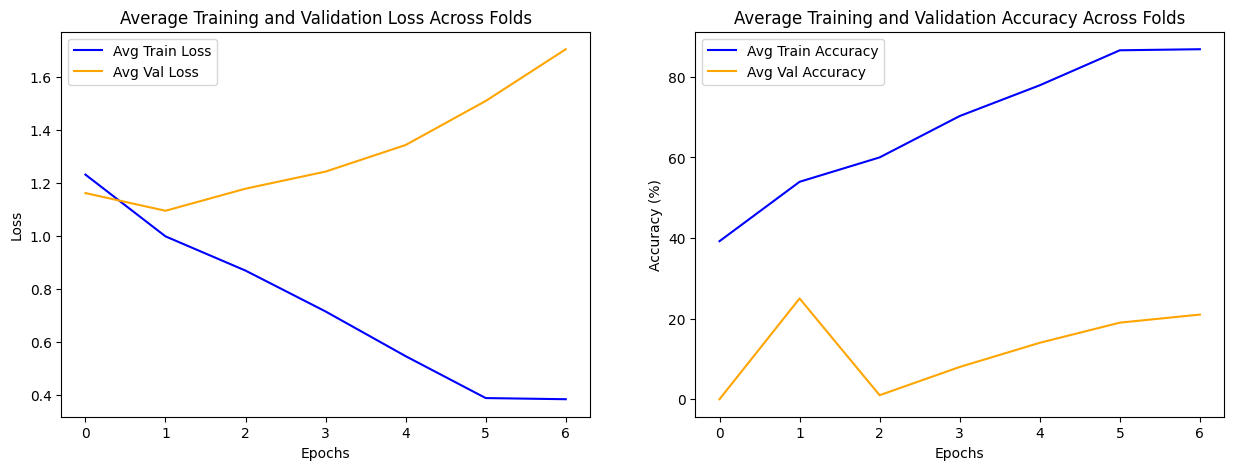

In [6]:
# Compute average training and validation metrics across folds
# Pad shorter lists to the maximum length with the last value
max_epochs = max(len(loss) for loss in fold_results['train_loss'])
avg_train_loss = []
avg_val_loss = []
avg_train_acc = []
avg_val_acc = []

for i in range(max_epochs):
    train_loss_i = [fold_results['train_loss'][f][i] if i < len(fold_results['train_loss'][f]) 
                    else fold_results['train_loss'][f][-1] for f in range(k_folds)]
    val_loss_i = [fold_results['val_loss'][f][i] if i < len(fold_results['val_loss'][f]) 
                  else fold_results['val_loss'][f][-1] for f in range(k_folds)]
    train_acc_i = [fold_results['train_acc'][f][i] if i < len(fold_results['train_acc'][f]) 
                   else fold_results['train_acc'][f][-1] for f in range(k_folds)]
    val_acc_i = [fold_results['val_acc'][f][i] if i < len(fold_results['val_acc'][f]) 
                 else fold_results['val_acc'][f][-1] for f in range(k_folds)]
    
    avg_train_loss.append(np.mean(train_loss_i))
    avg_val_loss.append(np.mean(val_loss_i))
    avg_train_acc.append(np.mean(train_acc_i))
    avg_val_acc.append(np.mean(val_acc_i))

# Plot average metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(avg_train_loss, label="Avg Train Loss", color="blue")
ax1.plot(avg_val_loss, label="Avg Val Loss", color="orange")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Average Training and Validation Loss Across Folds")
ax1.legend()

# Accuracy plot
ax2.plot(avg_train_acc, label="Avg Train Accuracy", color="blue")
ax2.plot(avg_val_acc, label="Avg Val Accuracy", color="orange")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Average Training and Validation Accuracy Across Folds")
ax2.legend()

plt.show()

# **Part 6: Generate Classification Report**

In [7]:
# Generate classification report for aggregated predictions
classes = dataset.classes
print("\nClassification Report (Across All Folds):")
print(classification_report(all_true_labels, all_predictions, target_names=classes))


Classification Report (Across All Folds):
                       precision    recall  f1-score   support

Bacterial leaf blight       0.22      0.28      0.24        40
           Brown spot       0.45      0.33      0.38        40
            Leaf smut       0.27      0.28      0.27        40

             accuracy                           0.29       120
            macro avg       0.31      0.29      0.30       120
         weighted avg       0.31      0.29      0.30       120



# **Part 7: Plot Confusion Matrix**

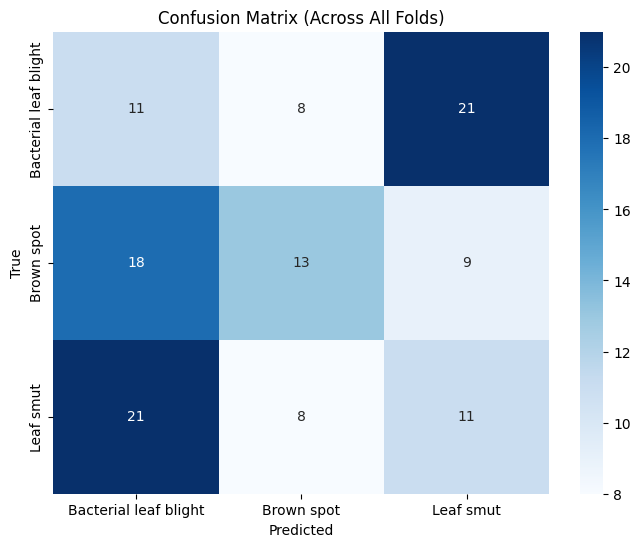

In [8]:
# Generate confusion matrix for aggregated predictions
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Across All Folds)')
plt.show()

# **Part 8: Plot ROC Curves and Compute AUC**

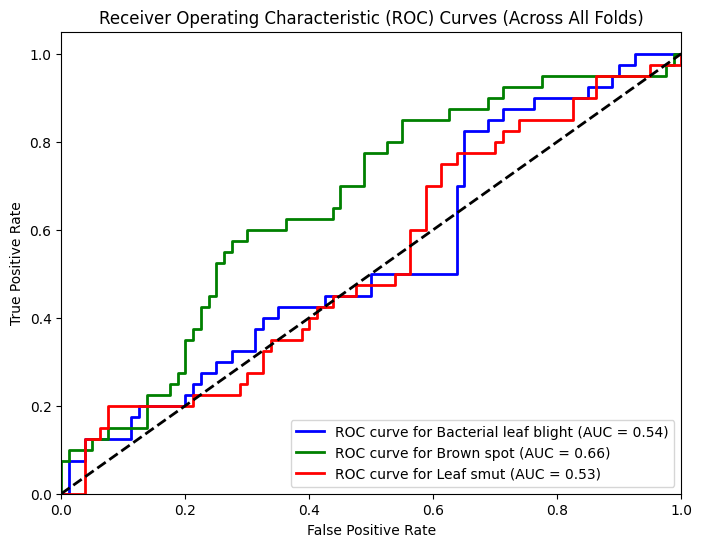


Per-Class AUC (Across All Folds):
Bacterial leaf blight: 0.54
Brown spot: 0.66
Leaf smut: 0.53


In [9]:
# Generate ROC Curve and AUC for aggregated predictions
true_labels_bin = label_binarize(all_true_labels, classes=[0, 1, 2])
n_classes = len(classes)
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], all_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves (Across All Folds)')
plt.legend(loc="lower right")
plt.show()

# Print per-class AUC
print("\nPer-Class AUC (Across All Folds):")
for i in range(n_classes):
    print(f"{classes[i]}: {roc_auc[i]:.2f}")

# **Part 9: Visualize Sample Predictions**

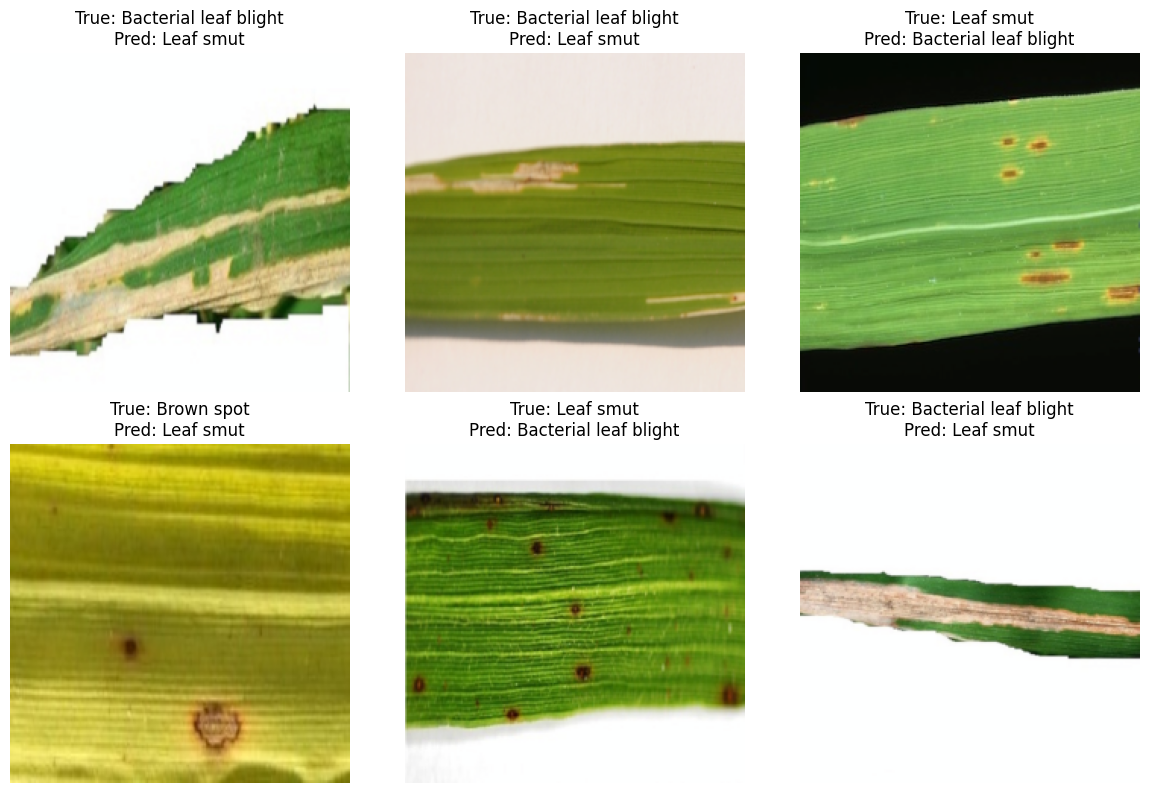

In [10]:
# Function to denormalize images for visualization
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std[:, None, None] + mean[:, None, None]
    return img

# Display sample predictions from aggregated test set
# Create a list of all test indices and corresponding predictions
test_indices = []
test_labels = []
test_preds = []
offset = 0
for fold in range(k_folds):
    fold_size = len(fold_results['true_labels'][fold])
    test_indices.extend(range(offset, offset + fold_size))
    test_labels.extend(fold_results['true_labels'][fold])
    test_preds.extend(fold_results['predictions'][fold])
    offset += fold_size

# Select random samples
sample_indices = np.random.choice(len(test_indices), size=6, replace=False)
plt.figure(figsize=(12, 8))
for i, sample_idx in enumerate(sample_indices):
    img, label = dataset[test_indices[sample_idx]]
    pred = test_preds[sample_idx]

    img = denormalize(img.numpy())
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {classes[label]}\nPred: {classes[pred]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

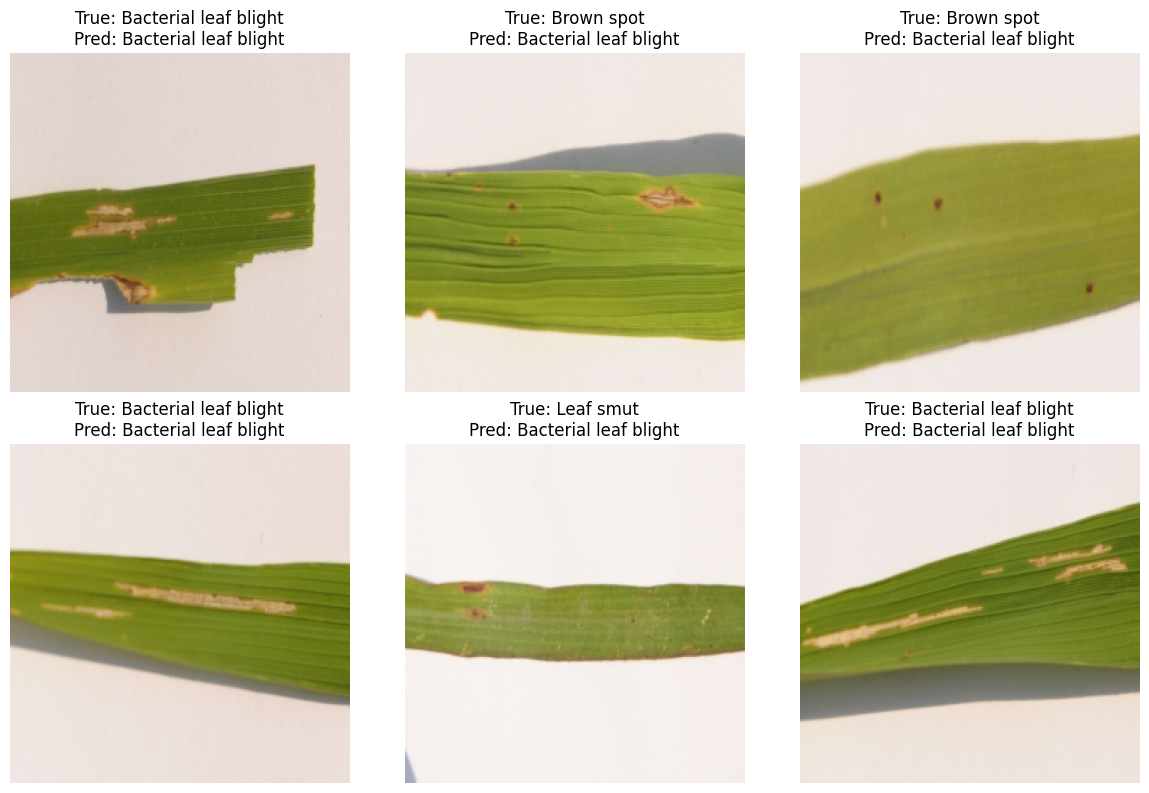

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

# Assuming dataset is already loaded as in your notebook
dataset = datasets.ImageFolder(root='/kaggle/input/rice-leaf-diseases/rice_leaf_diseases')
classes = dataset.classes  # Get class names

# Define test transformations (as in your notebook)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a test dataset (e.g., split from the main dataset)
# If you already have a test_loader or test_indices from K-fold or train-test split, use that
# For simplicity, let's assume a random split for demonstration
from torch.utils.data import Subset, DataLoader
np.random.seed(42)  # For reproducibility
indices = np.arange(len(dataset))
np.random.shuffle(indices)
train_size = int(0.8 * len(dataset))
test_indices = indices[train_size:]  # Use last 20% as test
test_data = Subset(dataset, test_indices)
test_data.dataset.transform = test_transform  # Apply test transforms

# Define function to denormalize images for visualization
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std[:, None, None] + mean[:, None, None]
    return img

# Compute predictions (assuming you have a trained model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomAlexNet(num_classes=3).to(device)  # Your model
model.eval()  # Set to evaluation mode

# Load model weights if saved (replace 'path_to_model.pth' with your model's path)
# model.load_state_dict(torch.load('path_to_model.pth'))

predictions = []
true_labels = []
with torch.no_grad():
    for img, label in DataLoader(test_data, batch_size=1):
        img = img.to(device)
        output = model(img)
        _, pred = torch.max(output, 1)
        predictions.append(pred.cpu().numpy()[0])
        true_labels.append(label.numpy()[0])

predictions = np.array(predictions)

# Display sample predictions
sample_indices = np.random.choice(len(test_data), size=6, replace=False)
plt.figure(figsize=(12, 8))
for i, idx in enumerate(sample_indices):
    img, label = test_data[idx]
    pred = predictions[idx]

    img = denormalize(img.numpy())
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {classes[label]}\nPred: {classes[pred]}")
    plt.axis('off')
plt.tight_layout()
plt.show()